# Classification for Custom Images


In [1]:
## library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt


In [2]:
## google drive에서 압축된 dataset download
import gdown
url = 'https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0'
fname = 'oxford_pet.zip'
gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0
To: /content/oxford_pet.zip
811MB [00:05, 136MB/s]


'oxford_pet.zip'

In [3]:
## oxford_pet.zip 확인
!ls -l

total 791576
-rw-r--r-- 1 root root 810565619 Oct 30 10:13 oxford_pet.zip
drwxr-xr-x 1 root root      4096 Oct 28 16:30 sample_data


In [4]:
## 압축풀기
!unzip -q oxford_pet.zip -d oxford_pet

In [5]:
## 압축이 풀린 directory 확인
!ls oxford_pet


annotations  images


### 개 / 고양이 2-class classification을 위한 Data 준비

In [6]:
## directory 설정
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'oxford_pet')
image_dir = os.path.join(data_dir, 'images')

In [7]:
## image file 수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))

7390


In [8]:
## image file들을 읽어서 channel이 3이 아닌 image는 삭제
for image_file in image_files:
  image_path = os.path.join(image_dir, image_file)
  image = Image.open(image_path)
  image_mode = image.mode
  if image_mode != 'RGB':
    print(image_file, image_mode)
    image = np.asarray(image)
    print(image.shape)
    os.remove(image_path)

Abyssinian_34.jpg P
(202, 250)
Egyptian_Mau_177.jpg P
(175, 246)
Egyptian_Mau_191.jpg P
(214, 300)
Egyptian_Mau_14.jpg RGBA
(800, 582, 4)
Egyptian_Mau_139.jpg P
(250, 350)
Egyptian_Mau_129.jpg L
(325, 299)
Egyptian_Mau_145.jpg P
(188, 216)
Egyptian_Mau_186.jpg RGBA
(275, 183, 4)
staffordshire_bull_terrier_22.jpg L
(500, 364)
staffordshire_bull_terrier_2.jpg L
(282, 500)
Egyptian_Mau_167.jpg P
(275, 183)
Abyssinian_5.jpg RGBA
(150, 200, 4)


In [9]:
## 개와 고양이 directory 생성
dog_dir = os.path.join(data_dir, 'dogs')
cat_dir = os.path.join(data_dir, 'cats')
os.makedirs(dog_dir, exist_ok=True)
os.makedirs(cat_dir, exist_ok=True)

In [10]:
## image file 중 개 이미지는 dogs 디렉토리에, 고양이 이미지는 cats 디렉토리에 복사
## file 이름의 첫 글자가 대문자로 시작하면 고양이, 소문자로 시작하면 개의 image임을 이용함

cat_cnt = 0
dog_cnt = 0
image_files = os.listdir(image_dir)
for image_file in image_files:  
  image_path = os.path.join(image_dir, image_file)
  ## file 이름의 첫글자가 소문자인지 확인: 개
  if image_file[0].islower():
    dog_cnt += 1
    copy_path = os.path.join(dog_dir, image_file)
  ## file 이름 첫글자가 대문자인 경우: 고양이
  else:
    cat_cnt += 1
    copy_path = os.path.join(cat_dir, image_file)
  ## image copy
  shutil.copy(image_path, copy_path)

In [11]:
print("총 복사된 image 수: {}".format(dog_cnt+cat_cnt))
print("개 image 수: {}".format(dog_cnt))
print("고양이 image 수: {}".format(cat_cnt))

총 복사된 image 수: 7378
개 image 수: 4988
고양이 image 수: 2390


In [12]:
## train data와 test data를 나누기 위한 디렉토리 생성
train_dir = os.path.join(data_dir, 'train_images')
train_dog_dir = os.path.join(train_dir, 'dogs')
train_cat_dir = os.path.join(train_dir, 'cats')

test_dir = os.path.join(data_dir, 'test_images')
test_dog_dir = os.path.join(test_dir, 'dogs')
test_cat_dir = os.path.join(test_dir, 'cats')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(train_dog_dir, exist_ok=True)
os.makedirs(train_cat_dir, exist_ok=True)

os.makedirs(test_dir, exist_ok=True)
os.makedirs(test_dog_dir, exist_ok=True)
os.makedirs(test_cat_dir, exist_ok=True)

In [13]:
## cats 디렉토리에서 random하게 2000장은 train 디렉토리로, 나머지는 test 디렉토리로 복사
cat_files = os.listdir(cat_dir)
rnd_idx = random.sample(range(len(cat_files)), len(cat_files))
test_idx = rnd_idx[2000:]
train_cnt = 0
test_cnt = 0
for idx, cat_file in enumerate(cat_files):
  cat_path = os.path.join(cat_dir, cat_file)
  if idx in test_idx:
    test_cnt += 1
    shutil.copy(cat_path, test_cat_dir)
  else:
    train_cnt += 1
    shutil.copy(cat_path, train_cat_dir)

print("train image 수: {}".format(train_cnt))
print("test image 수: {}".format(test_cnt))

train image 수: 2000
test image 수: 390


In [14]:
## 개 image가 더 많으므로 고양이 image 수에 맞추어 randome하게 2390장을 뽑아서 그 중 2000장은 train, 390장으 test 디렉토리로 복사
dog_files = os.listdir(dog_dir)
rnd_idx = random.sample(range(len(dog_files)), len(cat_files))
train_idx = rnd_idx[:2000]
test_idx = rnd_idx[2000:]
train_cnt = 0
test_cnt = 0
for idx, dog_file in enumerate(dog_files):
  dog_path = os.path.join(dog_dir, dog_file)
  if idx in test_idx:
    test_cnt += 1
    shutil.copy(dog_path, test_dog_dir)
  elif idx in train_idx:
    train_cnt += 1
    shutil.copy(dog_path, train_dog_dir)
  else:
    continue

print("train image 수: {}".format(train_cnt))
print("test image 수: {}".format(test_cnt))

train image 수: 2000
test image 수: 390


## TFRecord 만들기

In [21]:
IMG_SIZE = 224

In [22]:
## tfrecord 파일 저장할 directory 생성 및 파일 경로 설정
tfr_dir = os.path.join(data_dir, 'tfrecord')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'train.tfrecord')
tfr_test_dir = os.path.join(tfr_dir, 'test.tfrecord')

In [23]:
## tfrecord write 생성
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_test = tf.io.TFRecordWriter(tfr_test_dir)

In [24]:
## tfrecord file tutorial(간단버전)
with tf.io.TFRecordWriter('my_data.tfrecord') as f:
  f.write(b'This is the first record')
  f.write(b'And this is the second record')

In [25]:
dataset = tf.data.TFRecordDataset('my_data.tfrecord')
for item in dataset:
  print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


In [26]:
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [27]:
## train data의 tfrecord file 생성
n_train = 0
## cats
cat_files = os.listdir(train_cat_dir)
for cat_file in cat_files:
  cat_path = os.path.join(train_cat_dir, cat_file)
  image = Image.open(cat_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()
  label = 0
  example = tf.train.Example(features=tf.train.Features(feature={
            'image': _bytes_feature(bimage),
            'label': _int64_feature(label)}))
  writer_train.write(example.SerializeToString())
  n_train += 1

dog_files = os.listdir(train_dog_dir)
for dog_file in dog_files:
  dog_path = os.path.join(train_dog_dir, dog_file)
  image = Image.open(dog_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()
  label = 1
  example = tf.train.Example(features=tf.train.Features(feature={
            'image': _bytes_feature(bimage),
            'label': _int64_feature(label)}))
  writer_train.write(example.SerializeToString())
  n_train += 1

print(n_train)

4000


In [28]:
## test data의 tfrecord file 생성
n_test = 0
## cats
cat_files = os.listdir(test_cat_dir)
for cat_file in cat_files:
  cat_path = os.path.join(test_cat_dir, cat_file)
  image = Image.open(cat_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()
  label = 0
  example = tf.train.Example(features=tf.train.Features(feature={
            'image': _bytes_feature(bimage),
            'label': _int64_feature(label)}))
  writer_test.write(example.SerializeToString())
  n_test += 1

dog_files = os.listdir(test_dog_dir)
for dog_file in dog_files:
  dog_path = os.path.join(test_dog_dir, dog_file)
  image = Image.open(dog_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()
  label = 1
  example = tf.train.Example(features=tf.train.Features(feature={
            'image': _bytes_feature(bimage),
            'label': _int64_feature(label)}))
  writer_test.write(example.SerializeToString())
  n_test += 1

print(n_test)

780


In [29]:
!ls -l oxford_pet/tfrecord

total 702936
-rw-r--r-- 1 root root 117456896 Oct 30 10:22 test.tfrecord
-rw-r--r-- 1 root root 602345472 Oct 30 10:22 train.tfrecord


In [30]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'label': tf.io.FixedLenFeature([], tf.int64)
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255. 

    label = tf.cast(parsed_features['label'], tf.int64)

    return image, label

In [31]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_TRAIN_BATCH).repeat()
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())

In [32]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_test_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=N_VAL).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_VAL_BATCH).repeat()
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())

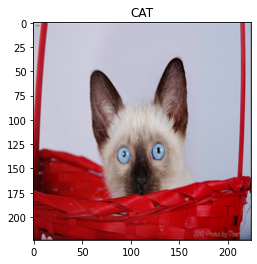

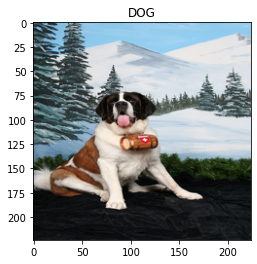

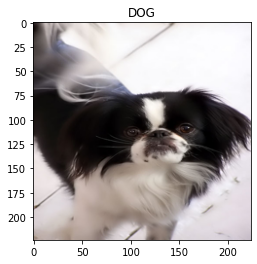

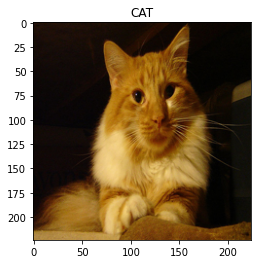

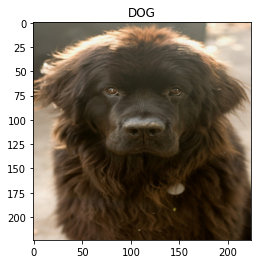

In [33]:
for image, label in train_dataset.take(5):
  plt.imshow(image[0])
  if label[0].numpy() == 0:
    plt.title('CAT')
  else:
    plt.title('DOG')  
  plt.show()

### Pretrained MobileNet으로 학습하기

In [34]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input, decode_predictions

In [35]:
## Pretrained MobileNet 가져오기
mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

17227776/17225924 [==============================] - 0s 0us/step


In [40]:
## Hyper Parameters
N_EPOCHS = 20
N_TRAIN_BATCH = 40
N_VAL_BATCH = 30
N_TRAIN = 4000
N_VAL = 780
learning_rate = 0.001
steps_per_epoch = N_TRAIN / N_TRAIN_BATCH
validation_steps = N_VAL / N_VAL_BATCH

In [41]:
## Model 만들기
from tensorflow.keras.layers import Dense, ReLU, Softmax, BatchNormalization, GlobalAveragePooling2D
def create_model():
    model = keras.Sequential()
    model.add(mobilenet)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(2))
    model.add(BatchNormalization())
    model.add(Softmax())
    return model

In [42]:
## Create model, compile & summary
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               131200    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
_________________________________________________________________
batch_normalization_3 (Batch (None, 2)                

In [43]:
history = model.fit(
    train_dataset,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/5
100/100 [==============================] - 26s 262ms/step - loss: 0.1609 - accuracy: 0.9770 - val_loss: 0.1349 - val_accuracy: 0.9487
Epoch 2/5
100/100 [==============================] - 26s 262ms/step - loss: 0.1375 - accuracy: 0.9850 - val_loss: 0.1579 - val_accuracy: 0.9679
Epoch 3/5
100/100 [==============================] - 26s 258ms/step - loss: 0.1230 - accuracy: 0.9815 - val_loss: 0.1614 - val_accuracy: 0.9653
Epoch 4/5
100/100 [==============================] - 26s 259ms/step - loss: 0.0970 - accuracy: 0.9927 - val_loss: 0.1071 - val_accuracy: 0.9795
Epoch 5/5
100/100 [==============================] - 26s 257ms/step - loss: 0.0962 - accuracy: 0.9850 - val_loss: 0.1106 - val_accuracy: 0.9730
